## Generating Intermediary Data for Non-Overlapping Evolutionary Models

Oh no! Unfortunately our new evolutionary models for brown dwarf masses do not align with those previously implemented, leaving a mass gap. To address this, we have decided to use Gaussian processes to fit the two data regimes (Phillips and Pisa) and generate the associated data in this range. The parameters in question are mass, luminosity, effective temperature, and log gravity. This notebook shows an example case for solar metallicity and a log age of ~7.13.

In [1]:
# importing necessary packages
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
from sklearn.preprocessing import StandardScaler

In [2]:
# importing compatible age fits files 
phillips = '/System/Volumes/Data/mnt/g/lu/models/evolution/Phillips2020/iso/z00/iso_7.128205127364955.fits'
pisa = '/System/Volumes/Data/mnt/g/lu/models/evolution/Pisa2011/iso/z015/iso_7.13.fits'

# loading tables and extracting data
phil_tbl = Table.read(phillips, format='fits')
pisa_tbl = Table.read(pisa, format='fits')

phil_mass = phil_tbl['Mass']
pisa_mass = pisa_tbl['col3']

phil_Teff = phil_tbl['Teff']
pisa_Teff = pisa_tbl['col2']

phil_L = phil_tbl['Luminosity']
pisa_L = pisa_tbl['col1']

phil_logg = phil_tbl['Gravity']
pisa_logg = pisa_tbl['col4']

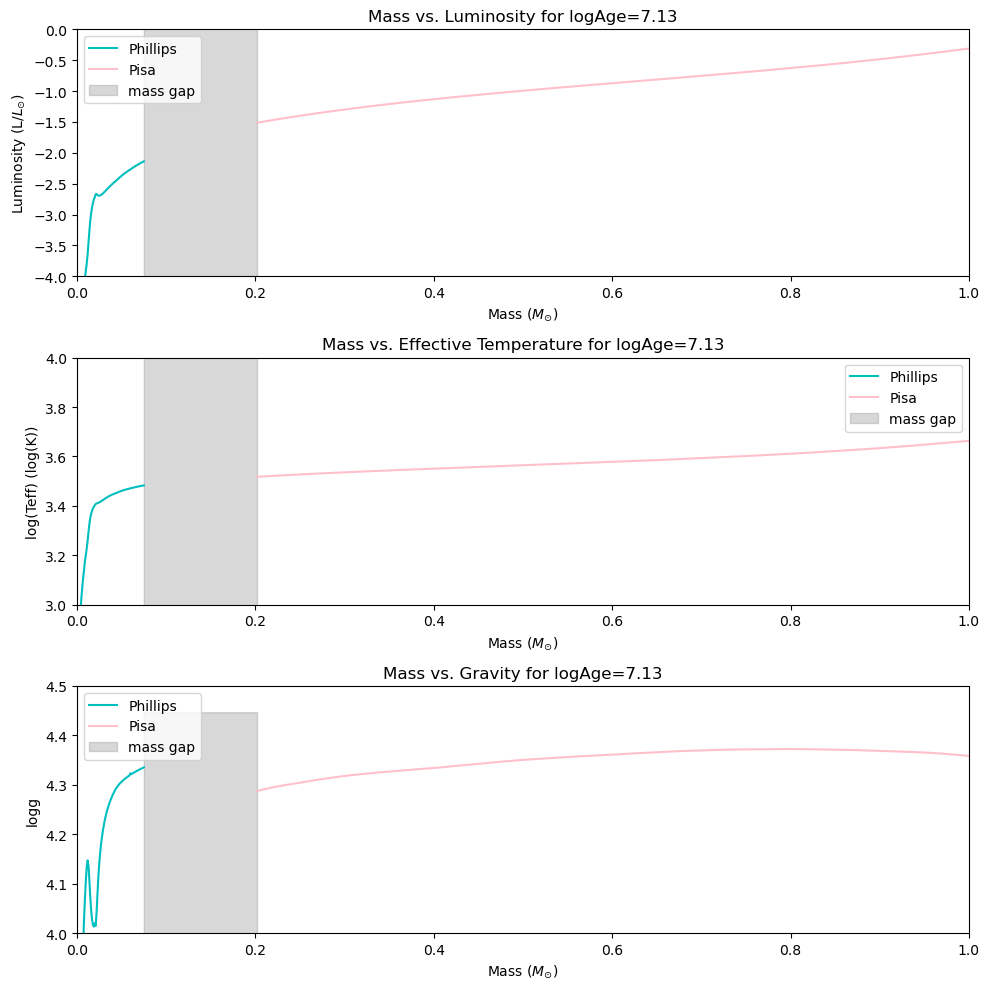

In [3]:
# creating graphs of mass vs. luminosity, Teff, and gravity
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# create array for mass gap
mass_gap = np.linspace(np.max(phil_mass), np.min(pisa_mass), 1000)

# mass vs. luminosity
axs[0].plot(phil_mass, phil_L, color='c', label='Phillips')
axs[0].plot(pisa_mass, pisa_L, color='pink', label='Pisa')
axs[0].set_title('Mass vs. Luminosity for logAge=7.13')
y_min0 = axs[0].get_ylim()[0]
y_max0 = axs[0].get_ylim()[1]
axs[0].fill_between(mass_gap, y_min0, y_max0, color='gray', label='mass gap', alpha=0.3)
axs[0].set_xlabel('Mass ($M_{\odot}$)')
axs[0].set_ylabel('Luminosity (L/$L_{\odot}$)')
axs[0].set_xlim(0,1)
axs[0].set_ylim(-4,0)
axs[0].legend()

# mass vs. Teff
axs[1].plot(phil_mass, phil_Teff, color='c', label='Phillips')
axs[1].plot(pisa_mass, pisa_Teff, color='pink', label='Pisa')
y_min1 = axs[1].get_ylim()[0]
y_max1 = axs[1].get_ylim()[1]
axs[1].fill_between(mass_gap, y_min1, y_max1, color='gray', label='mass gap', alpha=0.3)
axs[1].set_title('Mass vs. Effective Temperature for logAge=7.13')
axs[1].set_xlabel('Mass ($M_{\odot}$)')
axs[1].set_ylabel('log(Teff) (log(K))')
axs[1].set_xlim(0,1)
axs[1].set_ylim(3,4)
axs[1].legend()

# mass vs. logg (problem child)
axs[2].plot(phil_mass, phil_logg, color='c', label='Phillips')
axs[2].plot(pisa_mass, pisa_logg, color='pink', label='Pisa')
y_min2 = axs[2].get_ylim()[0]
y_max2 = axs[2].get_ylim()[1]
axs[2].fill_between(mass_gap, y_min2, y_max2, color='gray', label='mass gap', alpha=0.3)
axs[2].set_title('Mass vs. Gravity for logAge=7.13')
axs[2].set_xlabel('Mass ($M_{\odot}$)')
axs[2].set_ylabel('logg')
axs[2].set_xlim(0,1)
axs[2].set_ylim(4,4.5)
axs[2].legend()

fig.tight_layout()
plt.legend()
plt.show()

From these zoomed in graphs it becomes clear that though a mass gap is present, luminosty and effective temperature still seem to line up if a model connects them. In contrast, the graph for log gravity is very clearly disconnected, which is worth refining as new models continue to be generated. To best address this problem, we decided to use GaussianProcessRegressor with the Matern kernel, as through trial and error this appeared to be the best fit. We then decided to generate a chi-squared heat map for luminosity to find the ideal parameters for length_scale and nu.

In [4]:
# creating arrays
## mass
phil_mass = phil_tbl['Mass']
pisa_mass = pisa_tbl['col3']
combined_masses = np.concatenate([phil_mass, pisa_mass])

## Teff
phil_Teff = phil_tbl['Teff']
pisa_Teff = pisa_tbl['col2']
combined_Teff = np.concatenate([phil_Teff, pisa_Teff])

## Luminosity
phil_L = phil_tbl['Luminosity']
pisa_L = pisa_tbl['col1']
combined_L = np.concatenate([phil_L, pisa_L])

## logg
phil_logg = phil_tbl['Gravity']
pisa_logg = pisa_tbl['col4']
combined_logg = np.concatenate([phil_logg, pisa_logg])
print(np.min(phil_mass), np.max(pisa_mass))

0.0005 6.8546


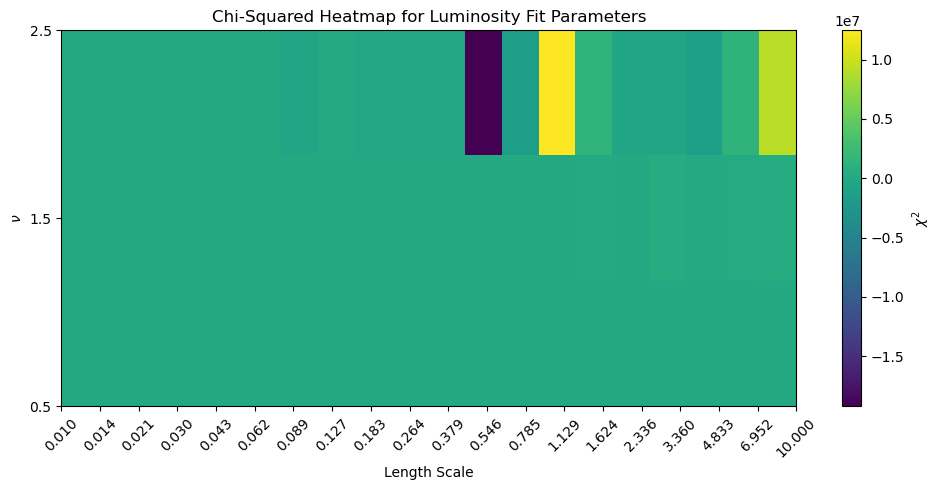

In [30]:
# creating input array (mass) and output array (luminosity)
X = combined_masses.reshape(-1, 1)
y = combined_L   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# Scale X and y
#X_scaler = StandardScaler()
#y_scaler = StandardScaler()

#X = X_scaler.fit_transform(combined_masses.reshape(-1, 1))
#y = y_scaler.fit_transform(combined_L.reshape(-1, 1)).ravel()

# Define grid
length_scales = np.logspace(-2, 1, 20)
nus = [0.5, 1.5, 2.5]  # available Matern values

chi2_map = np.zeros((len(nus), len(length_scales)))

# Grid search
for i, nu in enumerate(nus):
    for j, ls in enumerate(length_scales):
        kernel = Matern(length_scale=ls, nu=nu)
        gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
        
        try:
            gp.fit(X, y)
            y_pred = gp.predict(X)
            #for k, val in enumerate(y_pred):
            #    if (X[k] > 0.39) and (X[k] < 0.42):
            #        print(X[k], y[k], y_pred[k], (y - y_pred)[k])
            avg_diff = (np.sum(y - y_pred)) / len(y_pred)
            chi2 = np.sum(((y - y_pred)**2) / avg_diff)
            chi2_map[i, j] = chi2
        except Exception as e:
            chi2_map[i, j] = np.nan

# Plotting
plt.figure(figsize=(10, 5))
im = plt.imshow(chi2_map, aspect='auto', origin='lower',
                extent=[np.log10(length_scales[0]), np.log10(length_scales[-1]), 0, len(nus)-1],
                cmap='viridis')
plt.colorbar(im, label=r'$\chi^2$')
plt.xticks(np.log10(length_scales), labels=[f'{s:.3f}' for s in length_scales], rotation=45)
plt.yticks(range(len(nus)), labels=[str(n) for n in nus])
plt.xlabel('Length Scale')
plt.ylabel(r'$\nu$')
plt.title('Chi-Squared Heatmap for Luminosity Fit Parameters')
plt.tight_layout()
plt.show()


In [31]:
i_best, j_best = np.unravel_index(np.nanargmin(chi2_map), chi2_map.shape)
best_nu = nus[i_best]
best_length_scale = length_scales[j_best]
print(best_nu, best_length_scale)

2.5 0.5455594781168517


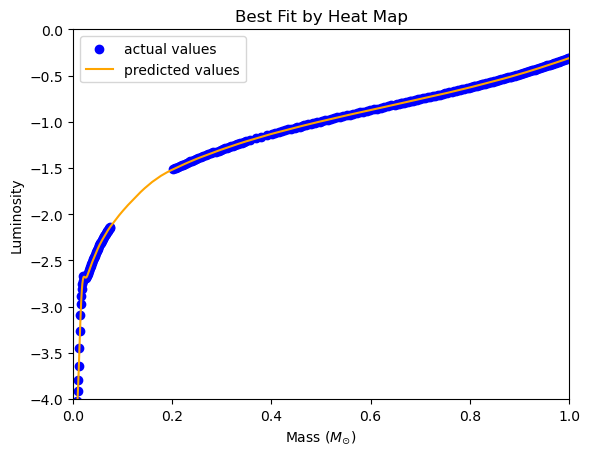

In [32]:
# Looking at physical interpretation of heatmap parameters

# creating input array (mass) and output array (everything else)
X = combined_masses.reshape(-1, 1)
y = combined_L   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# trying different kernel types
kernel = Matern(length_scale=best_length_scale, nu=best_nu)
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
gp.fit(X, y)
y_pred_1, sigma_1 = gp.predict(x, return_std=True)

plt.figure()
plt.scatter(X, combined_L, color='blue', label='actual values')
plt.plot(x, y_pred_1, color='orange', label='predicted values')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('Luminosity')
plt.title('Best Fit by Heat Map')
plt.xlim(0, 1)
plt.ylim(-4,0)
plt.legend()
plt.show()

This produced a pretty good fit! We can them repeat the process to find the best parameters for effective temperature and log gravity.

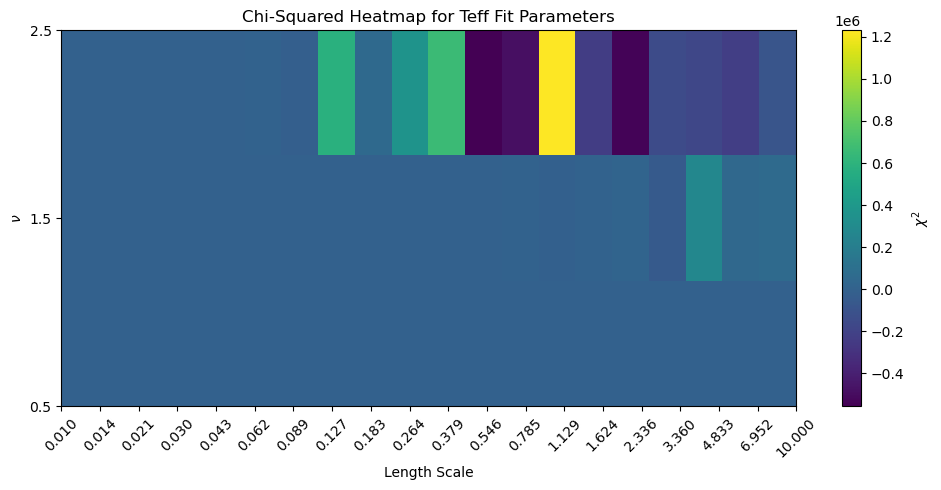

In [27]:
# creating input array (mass) and output array (luminosity)
X = combined_masses.reshape(-1, 1)
y_Teff = combined_Teff   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# Scale X and y
#X_scaler = StandardScaler()
#y_scaler = StandardScaler()

#X = X_scaler.fit_transform(combined_masses.reshape(-1, 1))
#y = y_scaler.fit_transform(combined_L.reshape(-1, 1)).ravel()

# Define grid
length_scales = np.logspace(-2, 1, 20)
nus = [0.5, 1.5, 2.5]  # available Matern values

chi2_map_Teff = np.zeros((len(nus), len(length_scales)))

# Grid search
for i, nu in enumerate(nus):
    for j, ls in enumerate(length_scales):
        kernel = Matern(length_scale=ls, nu=nu)
        gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
        
        try:
            gp.fit(X, y_Teff)
            y_pred_Teff = gp.predict(X)
            avg_diff_Teff = (np.sum(y_Teff - y_pred_Teff)) / len(y_pred_Teff)
            chi2_Teff = np.sum(((y_Teff - y_pred_Teff)**2) / avg_diff_Teff)
            #chi2_Teff = np.sum(((y_Teff - y_pred_Teff)**2) / y_pred_Teff)
            chi2_map_Teff[i, j] = chi2_Teff
        except Exception as e:
            chi2_map_Teff[i, j] = np.nan

# Plotting
plt.figure(figsize=(10, 5))
im = plt.imshow(chi2_map_Teff, aspect='auto', origin='lower',
                extent=[np.log10(length_scales[0]), np.log10(length_scales[-1]), 0, len(nus)-1],
                cmap='viridis')
plt.colorbar(im, label=r'$\chi^2$')
plt.xticks(np.log10(length_scales), labels=[f'{s:.3f}' for s in length_scales], rotation=45)
plt.yticks(range(len(nus)), labels=[str(n) for n in nus])
plt.xlabel('Length Scale')
plt.ylabel(r'$\nu$')
plt.title('Chi-Squared Heatmap for Teff Fit Parameters')
plt.tight_layout()
plt.show()


In [28]:
i_best_Teff, j_best_Teff = np.unravel_index(np.nanargmin(chi2_map_Teff), chi2_map_Teff.shape)
best_nu_Teff = nus[i_best_Teff]
best_length_scale_Teff = length_scales[j_best_Teff]
print(best_nu_Teff, best_length_scale_Teff)

2.5 0.5455594781168517


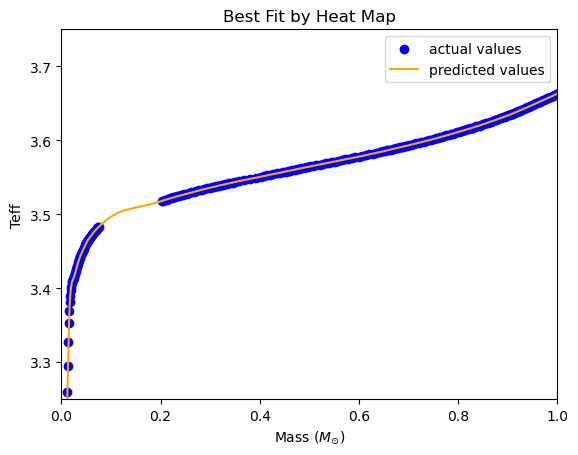

In [29]:
# Looking at physical interpretation of heatmap parameters

# creating input array (mass) and output array (everything else)
X = combined_masses.reshape(-1, 1)
y = combined_Teff   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# trying different kernel types
kernel = Matern(length_scale=best_length_scale_Teff, nu=best_nu_Teff)
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
gp.fit(X, y_Teff)
y_pred_Teff, sigma_Teff = gp.predict(x, return_std=True)

plt.figure()
plt.scatter(X, combined_Teff, color='blue', label='actual values')
plt.plot(x, y_pred_Teff, color='orange', label='predicted values')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('Teff')
plt.title('Best Fit by Heat Map')
plt.xlim(0, 1)
plt.ylim(3.25,3.75)
plt.legend()
plt.show()

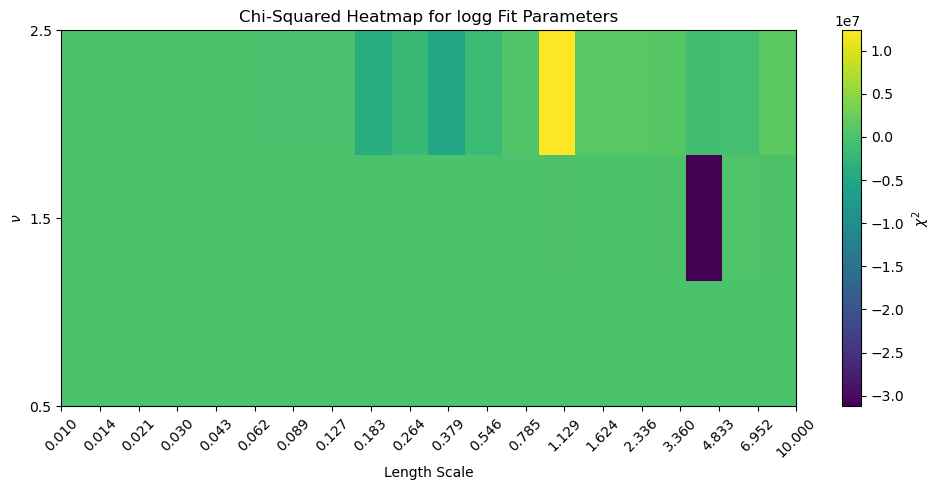

In [24]:
# creating input array (mass) and output array (logg)
X = combined_masses.reshape(-1, 1)
y_logg = combined_logg   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# Scale X and y
#X_scaler = StandardScaler()
#y_scaler = StandardScaler()

#X = X_scaler.fit_transform(combined_masses.reshape(-1, 1))
#y = y_scaler.fit_transform(combined_L.reshape(-1, 1)).ravel()

# Define grid
length_scales = np.logspace(-2, 1, 20)
nus = [0.5, 1.5, 2.5]  # available Matern values

chi2_map_logg = np.zeros((len(nus), len(length_scales)))

# Grid search
for i, nu in enumerate(nus):
    for j, ls in enumerate(length_scales):
        kernel = Matern(length_scale=ls, nu=nu)
        gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
        
        try:
            gp.fit(X, y_logg)
            y_pred_logg = gp.predict(X)
            avg_diff_logg = (np.sum(y_logg - y_pred_logg)) / len(y_pred_logg)
            chi2_logg = np.sum(((y_logg - y_pred_logg)**2) / avg_diff_logg)
            chi2_map_logg[i, j] = chi2_logg
        except Exception as e:
            chi2_map_logg[i, j] = np.nan

# Plotting
plt.figure(figsize=(10, 5))
im = plt.imshow(chi2_map_logg, aspect='auto', origin='lower',
                extent=[np.log10(length_scales[0]), np.log10(length_scales[-1]), 0, len(nus)-1],
                cmap='viridis')
plt.colorbar(im, label=r'$\chi^2$')
plt.xticks(np.log10(length_scales), labels=[f'{s:.3f}' for s in length_scales], rotation=45)
plt.yticks(range(len(nus)), labels=[str(n) for n in nus])
plt.xlabel('Length Scale')
plt.ylabel(r'$\nu$')
plt.title('Chi-Squared Heatmap for logg Fit Parameters')
plt.tight_layout()
plt.show()


In [25]:
i_best_logg, j_best_logg = np.unravel_index(np.nanargmin(chi2_map_logg), chi2_map_logg.shape)
best_nu_logg = nus[i_best_logg]
best_length_scale_logg = length_scales[j_best_logg]
print(best_nu_logg, best_length_scale_logg)

1.5 4.832930238571752


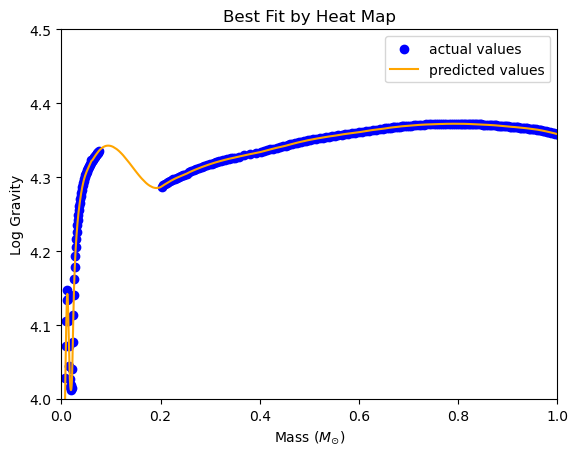

In [26]:
# Looking at physical interpretation of heatmap parameters

# creating input array (mass) and output array (everything else)
X = combined_masses.reshape(-1, 1)
y = combined_logg   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# trying different kernel types
kernel = Matern(length_scale=best_length_scale_logg, nu=best_nu_logg)
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
gp.fit(X, y_logg)
y_pred_logg, sigma_logg = gp.predict(x, return_std=True)

plt.figure()
plt.scatter(X, combined_logg, color='blue', label='actual values')
plt.plot(x, y_pred_logg, color='orange', label='predicted values')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('Log Gravity')
plt.title('Best Fit by Heat Map')
plt.xlim(0, 1)
plt.ylim(4.0,4.5)
plt.legend()
plt.show()